Code to account for angle of Optrix Camera and consequent lambertian emission of the Sample

## Constants

In [6]:
# We want to be able to provide xy coordinates, the angle of the camera, and the angle of the lid? and maximum temeprature to provide the expected measured temperature.

# Start with a helper function to account for lambertian emission and distance

import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
from math import radians as rad
from math import degrees as deg
import sympy as sp
from rich.progress import Progress
from rich.console import Console
import scipy

# Constants for camera and chip setup. Origin is defuined to be at the center of the lid on which the camrea is mounted. Chip offset constants are taken from old CAD; may be inaccurate.

# Vorrichtung mit Kamera
# CHIP_OFFSET_X = 3.537002 # millimeters, x offset of the top right corner of the chip from the origin
# CHIP_OFFSET_Y = 17.143916 # millimeters, y offset of the top right corner of the chip from the origin
# CHIP_OFFSET_Z = 166.800 # millimeters, z offset of the top right corner of the chip from the origin


# Neu Vorrichtung
CHIP_OFFSET_X = 3.675327 # millimeters, x offset of the top right corner of the chip from the origin
CHIP_OFFSET_Y = 14.096069 # millimeters, y offset of the top right corner of the chip from the origin
CHIP_OFFSET_Z = 155.700000 # millimeters, z offset of the top right corner of the chip from the origin

LID_ANGLE =  rad(-43.8400825)
MOUNT_ANGLE = rad(deg(LID_ANGLE) - 27.8106366)
MOUNT_OFFSET_Y = 19.10335 # millimeters, intersection of the y=axis with the plane in which the camera rotates (CAMERA_ANGLE rotation)
CAMERA_RADIUS = 38.86401 # millimeters, distance from the camera mount to the origin + MOUNT_OFFSET
CAMERA_HEIGHT = 91.11 # millimeters, height of the camera mount (center of rotation)
CAMERA_ANGLE = rad(22.5) # radians, angle of the camera from the vertical
CAMERA_LENGTH = 73.97719 # millimeters, length of the camera from the point of rotation to the lens

LENS_DIAMETER = 18 # millimeters, diameter of the camera lens
APERTURE_DIAMETER = 47 # millimeters, diameter of the hole in the lid through which the camera views the sample
APERTURE_DISTANCE = 29 # millimeters, distance from the origin to the center of the aperture
APERTURE_ANGLE = rad(deg(LID_ANGLE) + 17.4675436) # degrees, angle of the aperture from the y-axis
APERTURE_HEIGHT = 5 # millimeters, height of the aperture above the top of the lid
LID_THICKNESS = 12 # millimeters, thickness of the lid

LOWER_APERTURE_HEIGHT = CHIP_OFFSET_Z - LID_THICKNESS # millimeters, height of the bottom of the aperture above the sample
UPPER_APERTURE_HEIGHT = CHIP_OFFSET_Z + APERTURE_HEIGHT # millimeters, height of the top of the aperture above the sample

# EMISSIVITY_PAPER = 0.68
# STEFAN_BOLTZMANN = 5.67e-8 # W/m^2/K^4, Stefan-Boltzmann constant
AMBIENT_TEMPERATURE = 299.15 # Kelvin, ambient temperature


C:\Users\ssuub\AppData\Local\Temp\ipykernel_10852\3807833171.py:13: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  import scipy


## Functions

In [7]:
sub_limit = 50

CO = [CAMERA_RADIUS * np.sin(LID_ANGLE), CAMERA_RADIUS * np.cos(LID_ANGLE), CAMERA_HEIGHT]

LFM= [[-np.sin(MOUNT_ANGLE) * np.cos(CAMERA_ANGLE), -np.cos(MOUNT_ANGLE) * np.cos(CAMERA_ANGLE), np.sin(CAMERA_ANGLE)],
                       [np.cos(MOUNT_ANGLE), - np.sin(MOUNT_ANGLE), 0],
                       [-np.sin(MOUNT_ANGLE) * np.sin(CAMERA_ANGLE), -np.cos(MOUNT_ANGLE) * np.sin(CAMERA_ANGLE), - np.cos(CAMERA_ANGLE)]]

CFM = np.linalg.inv(LFM)

print(CFM)

def cameraChipVector(x, y, rho = 0, phi = 0, view_coords = False):
    coordinates = [CAMERA_LENGTH * np.sin(rho) * np.cos(phi),
                   CAMERA_LENGTH * np.sin(rho) * np.sin(phi),
                   CAMERA_LENGTH * np.cos(rho)]
    
    # Coordinates of the camera lens
    cx, cy, cz = np.matmul(coordinates, LFM)
    
    cx += CO[0]
    cy += CO[1]
    cz += CO[2]
    
    # Cartesian vector components from the chip to the camera lens
    rx = cx - CHIP_OFFSET_X - x
    ry = cy + CHIP_OFFSET_Y - y
    rz = cz + CHIP_OFFSET_Z

    if view_coords:
        print(rx, ry, rz) 

    return rx, ry, rz

def apertureRadii(x, y, rho = 0, phi = 0):
    rx, ry, rz = cameraChipVector(x, y, rho, phi)
    #print(rx, ry, rz)
    
    # Deterimes the angle of the point on the camera to the chip from the vertical
    theta = np.arctan2(np.sqrt(rx**2 + ry**2), rz)

    # Find the x and y coordinates of the center of the aperture from the sample origin
    aperture_x = APERTURE_DISTANCE * np.sin(APERTURE_ANGLE) - CHIP_OFFSET_X - x
    aperture_y = APERTURE_DISTANCE * np.cos(APERTURE_ANGLE) + CHIP_OFFSET_Y - y
    # print("Aperture Center:", aperture_x, aperture_y)

    # Calculate the radius (with center at the aperture center) at which the camera vector intersects the bottom and top of the aperture
    radius_u = np.sqrt(((rx * UPPER_APERTURE_HEIGHT / rz) - aperture_x) ** 2 + ((ry * UPPER_APERTURE_HEIGHT / rz) - aperture_y) ** 2)
    radius_l = np.sqrt(((rx * LOWER_APERTURE_HEIGHT / rz) - aperture_x) ** 2 + ((ry * LOWER_APERTURE_HEIGHT / rz) - aperture_y) ** 2)
    
    return radius_l, radius_u

def pointTemp(x, y, maxTemp, rho = 0, phi = 0):
    rx, ry, rz = cameraChipVector(x, y, rho, phi)
    #print(rx, ry, rz)
    
    # Deterimes the angle of the point on the camera to the chip from the vertical
    theta = np.atan2(np.sqrt(rx**2 + ry**2), rz)

    # Calculate the radius (with center at the aperture center) at which the camera vector intersects the bottom and top of the aperture
    radius_l, radius_u = apertureRadii(x, y, rho, phi)
    #print("Radius Lower:", radius_l, "Radius Upper:", radius_u)
    
    # Calculate the temperature based on the angle
    if (radius_l > APERTURE_DIAMETER / 2) or (radius_u > APERTURE_DIAMETER / 2):
        rectifiedTemp = AMBIENT_TEMPERATURE  # If the camera vector is blocked by the lid, return ambient temperature
    else:
        rectifiedTemp = ((maxTemp ** 4) * np.cos(theta)) ** 0.25
    return rectifiedTemp

def approxTemp(x, y, maxTemp, resolution = 20):
    maxRho = np.arcsin(LENS_DIAMETER / (2 * CAMERA_LENGTH))
    for i in range(resolution):
        rho = maxRho * i / resolution
        for j in range((i + 1)**2):
            phi = 2 * np.pi * (j + 0.5) / (i + 1)**2
            if i == 0 and j == 0:
                netTemp = pointTemp(x, y, maxTemp, rho, phi)
            else:
                netTemp += pointTemp(x, y, maxTemp, rho, phi)

    avgTemp = netTemp * 6 / ((2 * resolution + 1) * (resolution + 1) * (resolution))
    

    return avgTemp


print(pointTemp(0, 0, 150 + 273.15, 0.12196125, np.pi))
print(pointTemp(30, 2, 150 + 273.15, 0.12196125, np.pi))
print(pointTemp(2, 30, 150 + 273.15, 0.12196125, np.pi))
print(pointTemp(30, 30, 150 + 273.15, 0.12196125, np.pi))

# print(getTemp(30, 30, 150 + 273.15))


[[ 0.87690493  0.31480895  0.36322592]
 [-0.29084555  0.94915506 -0.12047217]
 [ 0.38268343 -0.         -0.92387953]]
420.7597202166675
418.4221062741014
422.76415219446307
420.1841475947644


### Inverse Function

In [8]:
def correctedTemp(x, y, temperature, resolution = 2):

    maxRho = np.arcsin(LENS_DIAMETER / (2 * CAMERA_LENGTH))
    numPoints = (2 * resolution + 1) * (resolution + 1) * (resolution) / 6


    # count how many rays are occluded given the resolution
    occludedCounter = 0
    for i in range(resolution):
        rho = maxRho * i / resolution
        for j in range((i + 1)**2):
            phi = 2 * np.pi * (j + 0.5) / (i + 1)**2
            radius_l, radius_u = apertureRadii(x, y, rho, phi)
            if (radius_l > APERTURE_DIAMETER / 2) or (radius_u > APERTURE_DIAMETER / 2):
                occludedCounter += 1
    
    # Intermediate calculation of temperature (accounting for occlusion but not Lambertian emission)
    if occludedCounter == 0:
        interimTemp = temperature
    else:
        interimTemp = (temperature * numPoints - AMBIENT_TEMPERATURE * occludedCounter) / (numPoints - occludedCounter)

    
    # Deterimes the angle of the point on the camera to the chip from the vertical
    rx, ry, rz = cameraChipVector(x, y, rho, phi)
    theta = np.atan2(np.sqrt(rx**2 + ry**2), rz)
    
    trueTemp = (interimTemp ** 4 / np.cos(theta)) ** 0.25
    return trueTemp

### Integral Calculation Functions

The following functions are attempts at integrating the point temperature over all angles of light converged by the camera lens.

In [186]:

# For a parametrization t of the circumference of the aperture using the initially defined coordinates, we transform to spherical coordinates used by the camera.
# - rhoBounds is the parametrization of "theta" in spherical coordinates as a function of t
# - invPhiBounds is the inverse of the parametrization of "phi" in spherical coordinates as a function of t
#   - The domain of t is [0, 2pi]
# Thus, we can find rho as a function of phi, and use the following function as bounds for integration
def boundsTest(t):
    x = APERTURE_DIAMETER * np.cos(t) / 2 - (APERTURE_DISTANCE * np.sin(APERTURE_ANGLE)) - CO[0]
    y = APERTURE_DIAMETER * np.sin(t) / 2 - (APERTURE_DISTANCE * np.cos(APERTURE_ANGLE)) - CO[1]
    z = APERTURE_HEIGHT - CO[2]

    if type(x) == np.ndarray:
        z = np.full(x.shape, z)
        rx, ry, rz = np.transpose(np.matmul(np.stack(([x,y,z]),axis = 1), CFM))
    else:
        rx, ry, rz = np.matmul(np.array([x, y, z]), CFM)

    return rx, ry, rz

# def rhoBounds(t):
#     x = APERTURE_DIAMETER * np.cos(t) / 2 - (APERTURE_DISTANCE * np.sin(APERTURE_ANGLE)) - CO[0]
#     y = APERTURE_DIAMETER * np.sin(t) / 2 - (APERTURE_DISTANCE * np.cos(APERTURE_ANGLE)) - CO[1]
#     z = APERTURE_HEIGHT - CO[2]
    
#     if type(x) == np.ndarray:
#         z = np.full(x.shape, z)
#         rx, ry, rz = np.transpose(np.matmul(np.stack(([x,y,z]),axis = 1), CFM))

#     else:
#         rx, ry, rz = np.matmul(np.array([x, y, z]), CFM)
    
#     return np.arccos(rz / np.sqrt(rx**2 + ry**2 + rz**2))

# def phiBounds(t):
#     x = APERTURE_DIAMETER * np.cos(t) / 2 - (APERTURE_DISTANCE * np.sin(APERTURE_ANGLE)) - CO[0]
#     y = APERTURE_DIAMETER * np.sin(t) / 2 - (APERTURE_DISTANCE * np.cos(APERTURE_ANGLE)) - CO[1]
#     z = APERTURE_HEIGHT - CO[2]

#     if type(x) == np.ndarray:
#         z = np.full(x.shape, z)
#         rx, ry, rz = np.transpose(np.matmul(np.stack(([x,y,z]),axis = 1), CFM))

#     else:
#         rx, ry, rz = np.matmul(np.array([x, y, z]), CFM)
    
#     return np.arctan2(ry, rx)

# Sorry for the multitude of indexed variables; this equation was derived by hand. There may be a more succinct way to express this using a matrix multiplication.
def invPhiBounds(phi):
    arccosNum = (CO[0] * CFM[0][1] + CO[1] * CFM[1][1] + CO[2] * CFM[2][1]) - (CO[0] * CFM[0][0] + CO[1] * CFM[1][0] + CO[2] * CFM[2][0]) * np.tan(phi)
    arccosDen = np.sqrt(APERTURE_DIAMETER / 2 * (CFM[1][1] - CFM[1][0] * np.tan(phi))**2 + (CFM[0][1] - CFM[0][0] * np.tan(phi))**2)

    # if arccosNum / arccosDen > 1 or arccosNum / arccosDen < -1:
    #     print(arccosNum / arccosDen)
    #     arccosNum = arccosDen
    
    t = np.arccos(arccosNum / arccosDen) + np.arctan2((CFM[1][1] - CFM[1][0] * np.tan(phi)), (CFM[0][1] - CFM[0][0] * np.tan(phi)))

    return t

# rhoBounds(invPhiBounds(phi))

# def getTemp(x, y, maxTemp):
#     netTemp = scipy.integrate.quad(lambda phi: scipy.integrate.quad(lambda rho: pointTemp(x, y, maxTemp, rho, phi) * (CAMERA_LENGTH ** 2) * np.sin(rho),
#                                                                     0, 
#                                                                     np.arcsin(LENS_DIAMETER / (2 * CAMERA_LENGTH)),
#                                                                     point = )[0],
#                                    0,
#                                    2 * np.pi,
#                                    limit = sub_limit)
#     lensArea = scipy.integrate.quad(lambda rho: (CAMERA_LENGTH ** 2) * np.sin(rho), 0, np.arcsin(LENS_DIAMETER / (2 * CAMERA_LENGTH)))[0] * 2 * np.pi
#     avgTemp = netTemp[0] / lensArea
#     return avgTemp

# cameraChipVector(0, 0, view_coords = True)

print(pointTemp(0, 0, 150 + 273.15, 0.12196125, np.pi))
print(pointTemp(30, 2, 150 + 273.15, 0.12196125, np.pi))
print(pointTemp(2, 30, 150 + 273.15, 0.12196125, np.pi))
print(pointTemp(30, 30, 150 + 273.15, 0.12196125, np.pi))

# print(getTemp(30, 30, 150 + 273.15))


299.15
299.15
423.14259031729773
299.15


## Plot

In [9]:
x_coords = np.arange(2, 32, 2)
y_coords = np.arange(2, 32, 2)
sample_temp = 125

normal_temp = np.ones((15,15)) * (273.15 + sample_temp) - 273.15
angle_temp = np.zeros((15,15))
point_temp = np.zeros((15,15))
corrected_temp = np.zeros((15,15))

with Progress(console=Console(force_terminal=True, force_jupyter=False)) as p:
    task1 = p.add_task("Calculating Angle Temp...", total=15*15)
    for x in range(len(x_coords)):
        for y in range(len(y_coords)):
            angle_temp[y,x] = approxTemp(x_coords[x], y_coords[y], 273.15 + sample_temp) - 273.15
            p.update(task1, advance=1)

    for x in range(len(x_coords)):
        for y in range(len(y_coords)):
            point_temp[y,x] = pointTemp(x_coords[x], y_coords[y], 273.15 + sample_temp) - 273.15

with Progress(console=Console(force_terminal=True, force_jupyter=False)) as p:
    task2 = p.add_task("Calculating Corrected Temp...", total=15*15)
    for x in range(len(x_coords)):
        for y in range(len(y_coords)):
            corrected_temp[y,x] = correctedTemp(x_coords[x], y_coords[y], angle_temp[y,x] + 273.15, 2) - 273.15
            p.update(task2, advance=1)



Calculating Angle Temp... ---------------------------------------- 100% 0:00:0000:0100:01
Calculating Corrected Temp... ------------------------------------ 100% 0:00:00


124.86395615679771


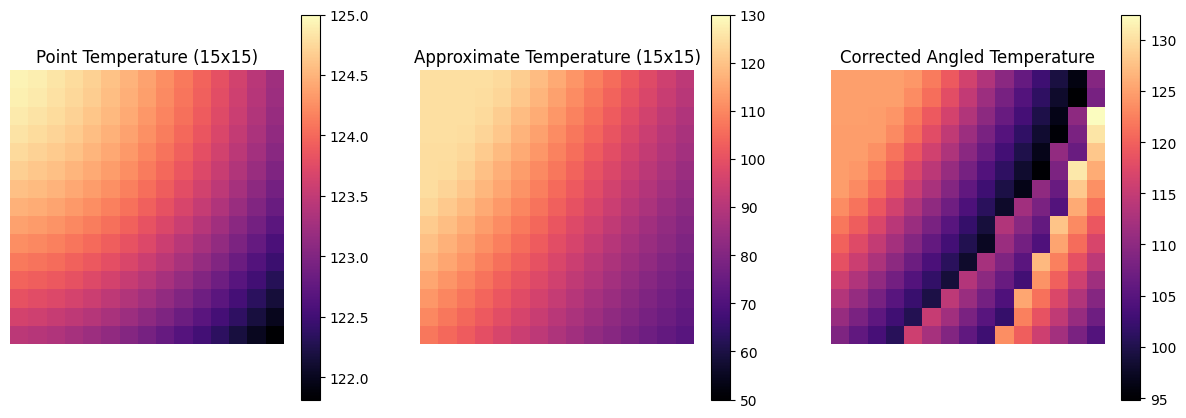

In [10]:

plt.close(2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5), num=2)

ax1.set_title("Point Temperature (15x15)")
img1 = ax1.imshow(point_temp, interpolation='nearest',
                    cmap = 'magma',
                    origin = 'lower',
                    #vmin = np.min(angle_temp),
                    vmax = sample_temp
                    )
ax1.set_axis_off()


ax2.set_title("Approximate Temperature (15x15)")
img2 = ax2.imshow(angle_temp, interpolation='nearest',
                    cmap = 'magma',
                    origin = 'lower',
                    vmin = 50,
                    vmax = 130
                    )
ax2.set_axis_off()
print(np.max(angle_temp))

ax3.set_title("Corrected Angled Temperature")
img3 = ax3.imshow(corrected_temp, interpolation='nearest',
                    cmap = 'magma',
                    origin = 'lower'
                    )
ax3.set_axis_off()

# ax3.set_title("Difference in Temperature (15x15)")
# img3 = ax3.imshow(point_temp - angle_temp, interpolation='nearest',
#                     cmap = 'bwr',
#                     origin = 'lower',
#                     vmin = - np.max(np.abs(point_temp - angle_temp)),
#                     vmax = np.max(np.abs(point_temp - angle_temp))
#                     )
# ax3.set_axis_off()


plt.colorbar(img1, cmap = 'magma')
plt.colorbar(img2, cmap = 'magma')
plt.colorbar(img3, cmap = 'magma')

plt.show()

### Old Plot

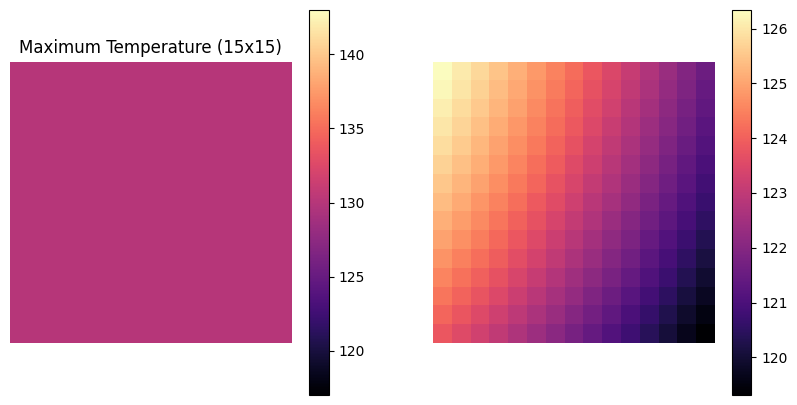

In [150]:
plt.close(1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5), num=1)

img2 = ax2.imshow(angle_temp, interpolation='nearest',
                    cmap = 'magma',
                    origin = 'lower')
ax2.set_axis_off()

ax1.set_title("Maximum Temperature (15x15)")
img1 = ax1.imshow(normal_temp, interpolation='nearest',
                    cmap = 'magma',
                    origin = 'lower')
ax1.set_axis_off()

plt.colorbar(img1, cmap = 'magma')
plt.colorbar(img2, cmap = 'magma')

plt.show()

# Fitting

In [1]:

plt.close(3)
.Mean Temp Grid.csv", delimiter=",")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5), num=3)

ax1.set_title("Point Temperature (15x15)")
img1 = ax1.imshow(angle_temp, interpolation='nearest',
                    cmap = 'magma',
                    origin = 'lower',
                    #vmin = np.min(angle_temp),
                    vmax = sample_temp
                    )
ax1.set_axis_off()

ax2.set_title("Approximate Temperature (15x15)")
img2 = ax2.imshow(mean, interpolation='nearest',
                    cmap = 'magma',
                    origin = 'lower',
                    vmin = 50,
                    vmax = 130
                    )
ax2.set_axis_off()
print(np.max(angle_temp))

ax3.set_title("Difference in Temperature (15x15)")
img3 = ax3.imshow(point_temp - angle_temp, interpolation='nearest',
                    cmap = 'bwr',
                    origin = 'lower',
                    vmin = - np.max(np.abs(point_temp - angle_temp)),
                    vmax = np.max(np.abs(point_temp - angle_temp))
                    )
ax3.set_axis_off()


plt.colorbar(img1, cmap = 'magma')
plt.colorbar(img2, cmap = 'magma')
plt.colorbar(img3, cmap = 'magma')

plt.show()

SyntaxError: unterminated string literal (detected at line 2) (3949092639.py, line 2)